In [6]:
%pip install netCDF4
%pip install zstandard
%pip install numcodecs
%pip install julia
%pip install xbitinfo
%pip install pooch

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import os
from netCDF4 import Dataset
import zstandard as zstd
import numcodecs
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbitinfo as xb

In [14]:
# Read in nc4 file based on variable name. Round if necessary.
# Returns byte representation.
def read_file_with_var(read_file_name, var_name, round):
    data = Dataset("data/" + read_file_name)

    var = data.variables[var_name]
    var_data = var[:]

    if round:
        if(var_name == "QLML"):
            std_dev = np.std(var_data)
            B = std_dev * 0.005
            
            # Apply linear quantization
            min_val = np.min(var_data)
            var_rounded = ((var_data - min_val) / B).round() * B + min_val
        else:
            var_rounded = var_data * 10 // 1 / 10
        output = var_rounded.tobytes()
    else:
        output = var_data.tobytes()
    
    return output

In [15]:
# Aggregates two variables from the same nc4 file into one
def stack_vars(read_file_name, var1, var2):
    data = Dataset("data/" + read_file_name)

    variable1 = data.variables[var1][:]
    variable2 = data.variables[var2][:]
    stacked = np.stack((variable1, variable2), axis=-1)
    
    output = stacked.tobytes()
    return output

In [16]:
# Aggregates multiple nc4 files of adjacent time steps
# Writes to file
def aggregate_files(file_paths):
    aggregated_dataset = xr.open_mfdataset(file_paths, combine="by_coords")
    aggregated_dataset.to_netcdf("data/2020_03_03_ aggregated.nc4", format="NETCDF4")

In [24]:
# Applies compression based on specified library
def compress(data, lib):
    if lib == "zstd":
        cctx = zstd.ZstdCompressor()
        compressed = cctx.compress(data)
    elif lib == "zlib":
        zlib = numcodecs.Zlib(level=9)
        compressed = zlib.encode(data)
    elif lib == "gzip":
        gzip = numcodecs.gzip.GZip(level=9)
        compressed = gzip.encode(data)
    elif lib == "blosc":
        blosc = numcodecs.Blosc(cname="blosclz", clevel=9, shuffle=numcodecs.blosc.Blosc.BITSHUFFLE, blocksize=0)
        compressed = blosc.encode(data)

    return compressed

In [25]:
# Shuffles data
def shuffle(data):
    shuffle = numcodecs.Shuffle()
    shuffled_data = shuffle.encode(data)
    return shuffled_data

In [26]:
# Rounds data using xbitinfo
# Writes to file
def xbitinfo_round(data):
    ds = xr.open_dataset("data/" + data)
    ds = ds.drop_vars('TAITIME')
    bitinfo = xb.get_bitinformation(ds, dim="lon")
    keepbits = xb.get_keepbits(bitinfo, inflevel=0.99)
    ds_bitrounded = xb.xr_bitround(ds, keepbits)
    ds_bitrounded.to_compressed_netcdf("data/output/xbitinfo/" + data)

In [27]:
def get_file_size(file):
    file_size = len(file)
    return file_size

In [28]:
def compression_ratio(original_file, compressed_file,):
    original_size = get_file_size(original_file)
    compressed_size = get_file_size(compressed_file)

    ratio = round(original_size / compressed_size, 3)

    data = [original_size, compressed_size, ratio]
    return data

In [ ]:
# Read in all variables from nc4 file
# Apply rounding, shuffling, and rounding+shuffling
# Apply multiple compression methods
def compress_all_vars(read_file_name):
    data = Dataset(f"data/{read_file_name}")

    compression_methods = ["zstd", "zlib", "gzip", "blosc"]
    compression_ratios = {}
    size_comparison = {}

    for var_name in data.variables.keys():
        original = read_file_with_var(read_file_name, var_name, False)
        rounded_data = read_file_with_var(read_file_name, var_name, True)
        shuffled_data = shuffle(original)
        shuffled_rounded_data = shuffle(rounded_data)

        data_variants = {
            "": original,
            "_shuffled": shuffled_data,
            "_rounded": rounded_data,
            "_shuffled_rounded": shuffled_rounded_data,
        }

        variant_ratios = {}
        variant_sizes = {}

        original_size = None

        for method in compression_methods:
            for suffix, variant_data in data_variants.items():
                compressed_obj = compress(variant_data, method)
                orig_size, comp_size, ratio = compression_ratio(original, compressed_obj)

                original_size = orig_size

                ratio_key = f"{method}_ratio{suffix}"
                size_key = f"{method}{suffix}"

                variant_ratios[ratio_key] = ratio
                variant_sizes[size_key] = comp_size

        size_comparison[var_name] = {"original": original_size, **variant_sizes}
        compression_ratios[var_name] = variant_ratios

    data.close()

    print(json.dumps(compression_ratios, indent=2))


    # ratio_write_path = "data/output/ratios/" + read_file_name + "_ratios.json"
    # comparison_write_path = "data/output/comparison/" + read_file_name + "_comparison.json"
    # os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    # os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    # with open(ratio_write_path, "w") as outfile:
    #     json.dump(compression_ratios, outfile, indent=4)
    #     print(f"Compression ratios written to {ratio_write_path}")
    
    # with open(comparison_write_path, "w") as outfile:
    #     json.dump(size_comparison, outfile, indent=4)
    #     print(f"File size comparisons written to {comparison_write_path}")

In [30]:
compress_all_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

{
  "lon": {
    "zstd_ratio": 6.304,
    "zstd_ratio_shuffled": 8.127,
    "zstd_ratio_rounded": 4.247,
    "zstd_ratio_shuffled_rounded": 4.905,
    "zlib_ratio": 4.856,
    "zlib_ratio_shuffled": 7.487,
    "zlib_ratio_rounded": 3.589,
    "zlib_ratio_shuffled_rounded": 4.83,
    "gzip_ratio": 4.825,
    "gzip_ratio_shuffled": 7.414,
    "gzip_ratio_rounded": 3.572,
    "gzip_ratio_shuffled_rounded": 4.8,
    "blosc_ratio": 5.844,
    "blosc_ratio_shuffled": 7.904,
    "blosc_ratio_rounded": 4.026,
    "blosc_ratio_shuffled_rounded": 4.638
  },
  "lat": {
    "zstd_ratio": 7.967,
    "zstd_ratio_shuffled": 11.536,
    "zstd_ratio_rounded": 5.595,
    "zstd_ratio_shuffled_rounded": 7.978,
    "zlib_ratio": 5.904,
    "zlib_ratio_shuffled": 12.246,
    "zlib_ratio_rounded": 4.678,
    "zlib_ratio_shuffled_rounded": 7.956,
    "gzip_ratio": 5.832,
    "gzip_ratio_shuffled": 11.942,
    "gzip_ratio_rounded": 4.633,
    "gzip_ratio_shuffled_rounded": 7.826,
    "blosc_ratio": 7.923,
    

In [ ]:
# Aggregate adjacent nc4 files and compress
aggregate_files(["data/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4", "data/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0100.V01.nc4"])
compress_all_vars("2020_03_03_ aggregated.nc4")

{
  "lon": {
    "zstd_ratio": 6.304,
    "zstd_ratio_shuffled": 8.127,
    "zstd_ratio_rounded": 4.247,
    "zstd_ratio_shuffled_rounded": 4.905,
    "zlib_ratio": 4.856,
    "zlib_ratio_shuffled": 7.487,
    "zlib_ratio_rounded": 3.589,
    "zlib_ratio_shuffled_rounded": 4.83,
    "gzip_ratio": 4.825,
    "gzip_ratio_shuffled": 7.414,
    "gzip_ratio_rounded": 3.572,
    "gzip_ratio_shuffled_rounded": 4.8,
    "blosc_ratio": 5.844,
    "blosc_ratio_shuffled": 7.904,
    "blosc_ratio_rounded": 4.026,
    "blosc_ratio_shuffled_rounded": 4.638
  },
  "lat": {
    "zstd_ratio": 7.967,
    "zstd_ratio_shuffled": 11.536,
    "zstd_ratio_rounded": 5.595,
    "zstd_ratio_shuffled_rounded": 7.978,
    "zlib_ratio": 5.904,
    "zlib_ratio_shuffled": 12.246,
    "zlib_ratio_rounded": 4.678,
    "zlib_ratio_shuffled_rounded": 7.956,
    "gzip_ratio": 5.832,
    "gzip_ratio_shuffled": 11.942,
    "gzip_ratio_rounded": 4.633,
    "gzip_ratio_shuffled_rounded": 7.826,
    "blosc_ratio": 7.923,
    

In [46]:
# Using xbitinfo, round and compress entire nc4 file
xbitinfo_round("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")
original_size = os.path.getsize("data/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")
xbitinfo_size = os.path.getsize("data/output/xbitinfo/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

print(f"Original file size: {original_size} bytes")
print(f"Xbitinfo file size: {xbitinfo_size} bytes")

ratio = round(original_size / xbitinfo_size, 3)
print(f"Compression ratio: {ratio}")


  0%|          | 0/5 [00:00<?, ?it/s]

DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None
DEBUG:julia:exception occured? None
DEBUG (37496) exception occured? None


Original file size: 10488337 bytes
Xbitinfo file size: 1569764 bytes
Compression ratio: 6.681


In [ ]:
# Various plotting functions
def _create_compression_ratio_plot(
    data,
    title,
    row_filter_1=None,
    row_filter_2=None,
    label_1='Original',
    label_2='Variant',
    drop_cols=None,
    figsize=(12, 6),
    base_colors=None,
    alt_colors=None,
    bar_width=0.1,
    y_lim=None
):
    """
    A flexible internal helper to create a bar chart given two row filters:
      - row_filter_1 picks the "first set" (e.g. non-shuffled / non-rounded),
      - row_filter_2 picks the "second set" (e.g. shuffled / rounded).
    
    If y_lim is provided, we set the y-axis limit to (0, y_lim) so that
    all plots share the same vertical scale.
    """

    if base_colors is None:
        base_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']  # Default
    if alt_colors is None:
        alt_colors = ['#4a90e2', '#ffa07a', '#32cd32', '#ff6347']   # Default

    df = pd.DataFrame(data)

    # Drop any columns not needed (e.g., "QLML")
    if drop_cols:
        df = df.drop(columns=drop_cols, errors='ignore')

    # Filter rows based on the provided lambdas (if provided)
    rows_set_1 = [idx for idx in df.index if row_filter_1 and row_filter_1(idx)]
    rows_set_2 = [idx for idx in df.index if row_filter_2 and row_filter_2(idx)]

    categories = df.columns
    x = np.arange(len(categories))

    fig, ax = plt.subplots(figsize=figsize)

    # Plot first set of rows
    for i, method in enumerate(rows_set_1):
        ax.bar(
            x + i * (bar_width * 2),
            df.loc[method],
            width=bar_width,
            label=f'{method} {label_1}',
            alpha=0.7,
            color=base_colors[i % len(base_colors)]
        )

    # Plot second set of rows
    for i, method in enumerate(rows_set_2):
        ax.bar(
            x + i * (bar_width * 2) + bar_width,
            df.loc[method],
            width=bar_width,
            label=f'{method} {label_2}',
            alpha=0.7,
            color=alt_colors[i % len(alt_colors)]
        )

    ax.set_title(title)
    ax.set_ylabel('Compression Ratio')
    ax.set_xticks(x + bar_width)
    ax.set_xticklabels(categories, rotation=45, ha='right')
    ax.legend()

    # Keep all subplots on the same vertical scale if y_lim is given
    if y_lim is not None:
        ax.set_ylim(0, y_lim)

    plt.tight_layout()
    return plt

def original_ratio_plot(data, y_lim=None):
    """Plots only 'original' ratios — i.e. no 'shuffled', no 'rounded'."""
    return _create_compression_ratio_plot(
        data=data,
        title='Compression Ratios by Algorithm',
        row_filter_1=lambda idx: ('shuffled' not in idx and 'rounded' not in idx),
        row_filter_2=None,   # No second set
        label_1='Original',
        drop_cols=None,
        bar_width=0.1,   # Adjust to preference
        y_lim=y_lim
    )

def shuffled_ratio_plot(data, y_lim=None):
    """Plots side-by-side bars for Original vs. Shuffled."""
    return _create_compression_ratio_plot(
        data=data,
        title='Non-Shuffled vs Shuffled Compression Ratios',
        row_filter_1=lambda idx: ('shuffled' not in idx and 'rounded' not in idx),
        row_filter_2=lambda idx: ('shuffled' in idx and 'rounded' not in idx),
        label_1='Original',
        label_2='Shuffled',
        drop_cols=None,
        bar_width=0.1,
        y_lim=y_lim
    )

def rounded_ratio_plot(data, y_lim=None):
    """Plots side-by-side bars for Original vs. Rounded."""
    return _create_compression_ratio_plot(
        data=data,
        title='Non-Rounded vs Rounded Compression Ratios',
        row_filter_1=lambda idx: ('shuffled' not in idx and 'rounded' not in idx),
        row_filter_2=lambda idx: ('rounded' in idx and 'shuffled' not in idx),
        label_1='Original',
        label_2='Rounded',
        drop_cols=['QLML'],  # Example: dropping the 'QLML' column
        bar_width=0.1,
        y_lim=y_lim
    )

def shuffle_rounded_ratio_plot(data, y_lim=None):
    """Plots side-by-side bars for Original vs. Shuffled+Rounded."""
    return _create_compression_ratio_plot(
        data=data,
        title='Shuffled and Rounded Compression Ratios',
        row_filter_1=lambda idx: ('shuffled' not in idx and 'rounded' not in idx),
        row_filter_2=lambda idx: ('shuffled_rounded' in idx),
        label_1='Original',
        label_2='Shuffled & Rounded',
        drop_cols=['QLML'],
        bar_width=0.1,
        y_lim=y_lim
    )

def ratio_plots(directory_path):
    """
    For each JSON file in directory_path (excluding those containing 'stacked'),
    read the data, compute a global y-limit from the maximum ratio (so all plots 
    share the same y-scale per file), create four plots (original, shuffled, 
    rounded, shuffled+rounded), save them as PNGs, and then show them.
    """
    for filename in os.listdir(directory_path):
        if filename.endswith('.json') and 'stacked' not in filename:
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                # Convert to DataFrame to find the global maximum
                df = pd.DataFrame(data)
                # If you want to ignore negative/invalid, you can do df[df>0].max().max()
                global_max = df.values.max() if not df.empty else None

                # Provide a small buffer above the max for better plotting
                y_lim = None
                if global_max is not None:
                    y_lim = global_max * 1.1

                os.makedirs(directory_path, exist_ok=True)

                # Generate all 4 plots with the same y-limit
                original_plot = original_ratio_plot(data, y_lim=y_lim)
                shuffled_plot = shuffled_ratio_plot(data, y_lim=y_lim)
                rounded_plot = rounded_ratio_plot(data, y_lim=y_lim)
                shuffle_rounded_plot = shuffle_rounded_ratio_plot(data, y_lim=y_lim)

                # Save to disk
                base_name = filename.replace('.json', '')
                original_plot.savefig(os.path.join(directory_path, f'{base_name}_original.png'))
                shuffled_plot.savefig(os.path.join(directory_path, f'{base_name}_shuffle.png'))
                rounded_plot.savefig(os.path.join(directory_path, f'{base_name}_rounded.png'))
                shuffle_rounded_plot.savefig(os.path.join(directory_path, f'{base_name}_shuffle_rounded.png'))

                # Show the plots
                original_plot.show()
                shuffled_plot.show()
                rounded_plot.show()
                shuffle_rounded_plot.show()


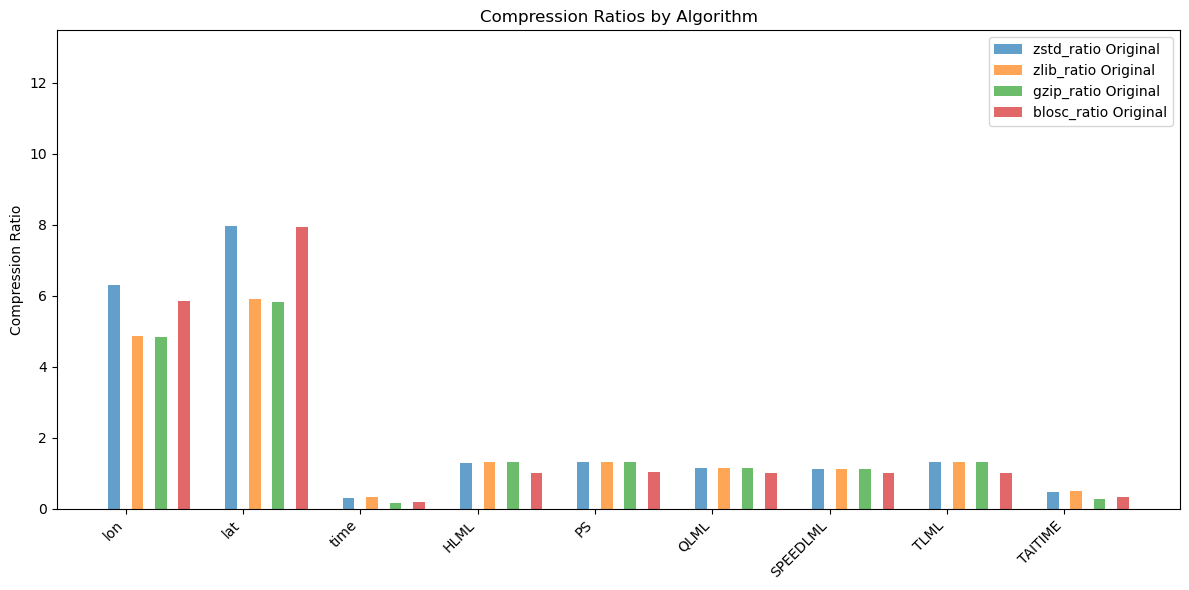

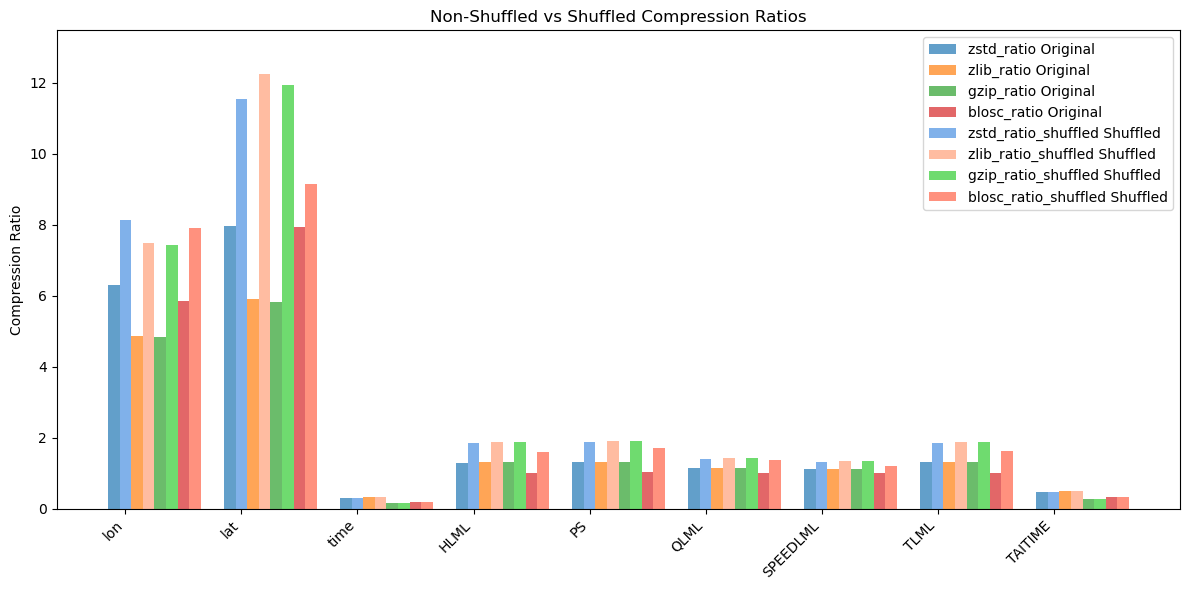

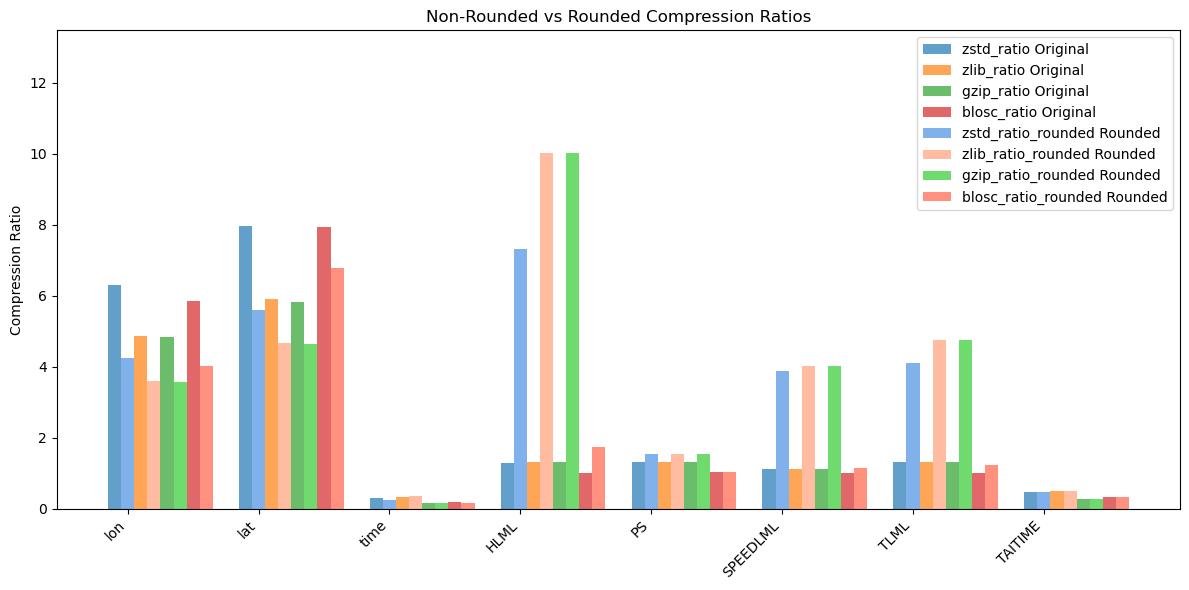

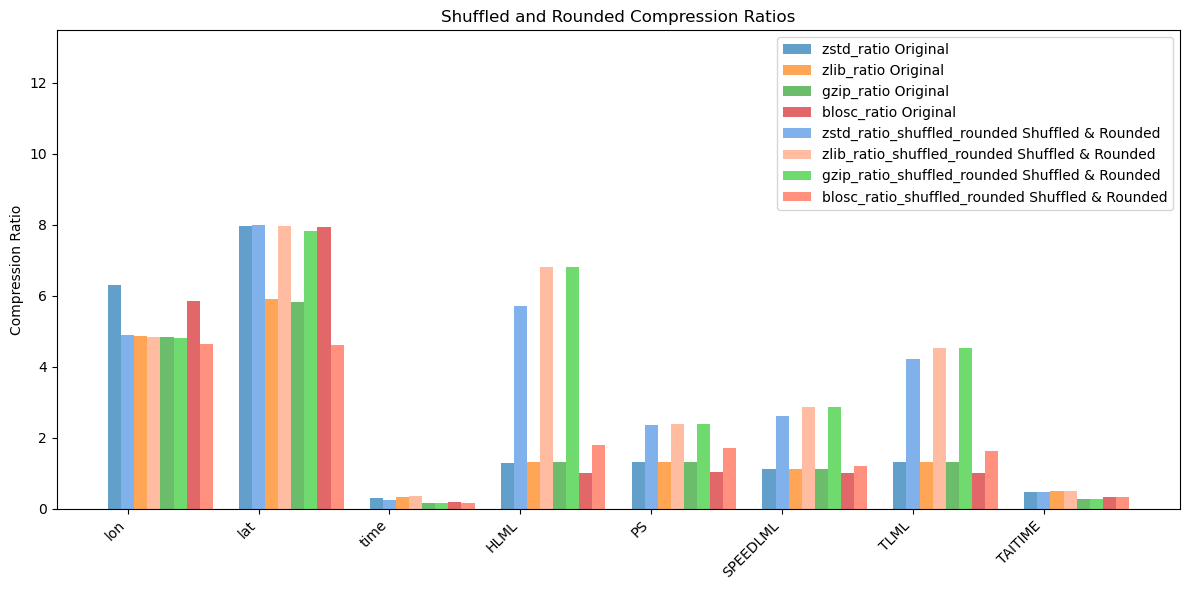

In [43]:
ratio_plots("data/output/ratios/")

In [435]:
# def comparison_plot(directory_path):
#     for filename in os.listdir(directory_path):
#         if filename.endswith('.json'):
#             file_path = os.path.join(directory_path, filename)
            
#             if os.path.isfile(file_path):
#                 with open(file_path, 'r') as file:
#                     data = json.load(file)

#                     keys = list(data.keys())
#                     libraries = [lib for lib in data[keys[0]].keys() if lib != "original"]
                    
#                     original_values = [data[key]['original'] for key in keys]
                    
#                     compressed_values = {lib: [data[key][lib] for key in keys] for lib in libraries}

#                     x = np.arange(len(keys))
#                     width = 0.8 / (len(libraries) + 1)

#                     fig, ax = plt.subplots(figsize=(12, 6))

#                     ax.bar(x - len(libraries)/2 * width, original_values, width, label='Original', color='skyblue')

#                     for i, lib in enumerate(libraries):
#                         ax.bar(x + (i + 1 - len(libraries) / 2) * width, compressed_values[lib], width, label=lib)

#                     ax.set_xlabel('Keys')
#                     ax.set_ylabel('Size')
#                     ax.set_title('Original vs Compressed Sizes by Library')
#                     ax.set_xticks(x)
#                     ax.set_xticklabels(keys, rotation=45)
#                     ax.legend()

#                     plt.tight_layout()

#                     output_dir = "data/output/comparison/"
#                     os.makedirs(output_dir, exist_ok=True)
#                     plt.savefig(os.path.join(output_dir, filename.replace('.json', '.png')))
#                     plt.show()

In [ ]:
def compress_all_stacked_vars(read_file_name):
    data = Dataset("data/" + read_file_name)
    compression_ratios = {}
    size_comparison = {}

    for var1_name in data.variables.keys():
        for var2_name in list(data.variables.keys())[list(data.variables.keys()).index(var1_name) + 1:]:
            skip = ["TAITIME", "time", "lon", "lat"]
            if var1_name in skip or var2_name in skip:
                continue

            original = stack_vars(read_file_name, var1_name, var2_name)
    
            zstd_compressed_obj = compress(original, "zstd")
            zstd_compression_data = compression_ratio(original, zstd_compressed_obj)

            zlib_compressed_obj = compress(original, "zlib")
            zlib_compression_data = compression_ratio(original, zlib_compressed_obj)

            gzip_compressed_obj = compress(original, "gzip")
            gzip_compression_data = compression_ratio(original, gzip_compressed_obj)

            blosc_compressed_obj = compress(original, "blosc")
            blosc_compression_data = compression_ratio(original, blosc_compressed_obj)

            compression_ratios[var1_name + "+" + var2_name] = {
                "zstd_ratio": zstd_compression_data[2],
                "zlib_ratio": zlib_compression_data[2],
                "gzip_ratio": gzip_compression_data[2],
                "blosc_ratio": blosc_compression_data[2],
            }

            size_comparison[var1_name + "+" + var2_name] = {
                "original": zstd_compression_data[0],
                "zstd": zstd_compression_data[1],
                "zlib": zlib_compression_data[1],
                "gzip": gzip_compression_data[1],
                "blosc": blosc_compression_data[1],
            }

    data.close()

    ratio_write_path = "data/output/ratios/" + read_file_name + "_stacked_ratios.json"
    comparison_write_path = "data/output/comparison/" + read_file_name + "_stacked_comparison.json"
    os.makedirs(os.path.dirname(ratio_write_path), exist_ok=True)
    os.makedirs(os.path.dirname(comparison_write_path), exist_ok=True)
    
    with open(ratio_write_path, "w") as outfile:
        json.dump(compression_ratios, outfile, indent=4)
        print(f"Compression ratios written to {ratio_write_path}")
    
    with open(comparison_write_path, "w") as outfile:
        json.dump(size_comparison, outfile, indent=4)
        print(f"File size comparisons written to {comparison_write_path}")

In [437]:
compress_all_stacked_vars("GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4")

Compression ratios written to data/output/ratios/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_stacked_ratios.json
File size comparisons written to data/output/comparison/GEOS.fp.asm.inst1_2d_lfo_Nx.20200303_0000.V01.nc4_stacked_comparison.json


In [438]:
def stacked_ratio_plot(directory_path):
    for filename in os.listdir(directory_path):
        if filename.endswith('.json') and 'stacked' in filename:
            file_path = os.path.join(directory_path, filename)
            
            if os.path.isfile(file_path):
                with open(file_path, 'r') as file:
                    data = json.load(file)

                    os.makedirs(directory_path, exist_ok=True)

                    compression_methods = list(next(iter(data.values())).keys())

                    plot_data = {method: [] for method in compression_methods}
                    labels = []

                    for label, ratios in data.items():
                        labels.append(label)
                        for method in compression_methods:
                            plot_data[method].append(ratios[method])

                    x = np.arange(len(labels))
                    width = 0.15

                    fig, ax = plt.subplots(figsize=(12, 6))

                    for i, method in enumerate(compression_methods):
                        ax.bar(x + i * width, plot_data[method], width, label=method)

                    ax.set_title('Compression Ratios for Different Combinations')
                    ax.set_xlabel('Combination')
                    ax.set_ylabel('Compression Ratio')
                    ax.set_xticks(x + width * (len(compression_methods) - 1) / 2)  # Center the ticks
                    ax.set_xticklabels(labels, rotation=45, ha='right')
                    ax.legend()

                    plt.tight_layout()
                    plt.savefig(os.path.join(directory_path, filename.replace('.json', '_stacked.png')))
                    plt.show()

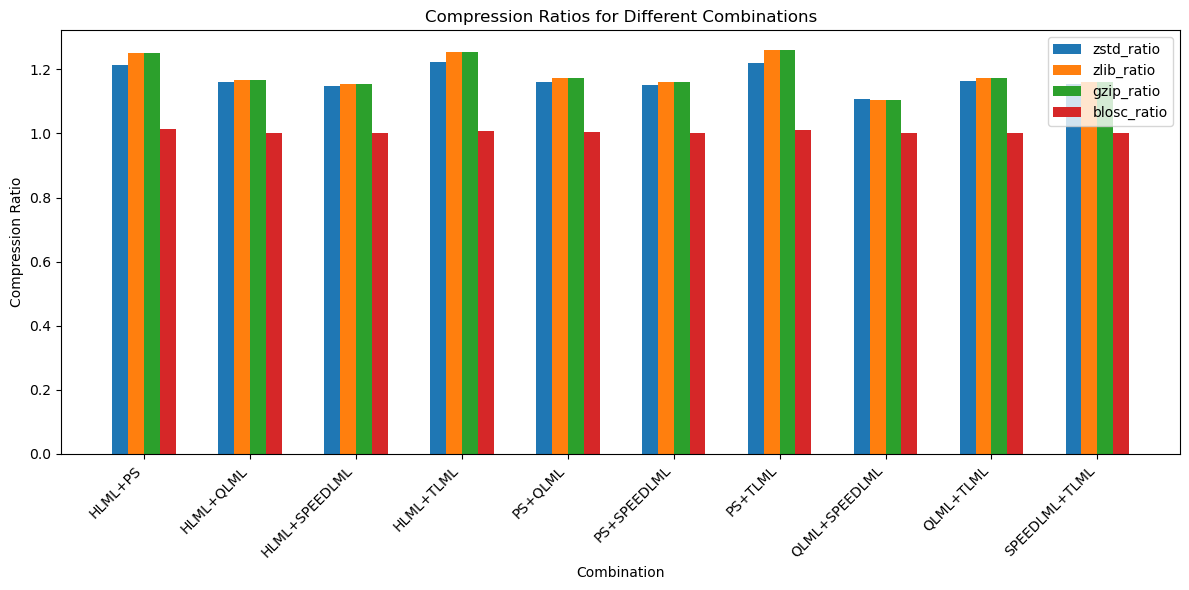

In [439]:
stacked_ratio_plot("data/output/ratios/")